**Run functions file**

In [1]:
%run romiumeter_functions.ipynb

**Optimum gain for Complementary and Madgwick filters for IMU-MOCAP**

In [ ]:
# Run gyro and complementary filter, Madgwick filter for different gains for IMU-MOCAP and save errors in destination path

data_path = get_the_data_path(r'C:\Phase1\IMU_data_copy')
for file in data_path:
    err = np.zeros(30)
    imu_file = file[0]
    mcp_file = file[1]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3)
    mcp = read_filter_data(mcp_file, datacols=mcp_col, filtcols=mcp_col[1:], sgwin=51, sgorder=3)
    mcp = upsample_mocap_data(imu, mcp)
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias)
    mocap_ang = estimate_rotation_angle_from_mocap(mcp)
    gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)
    err[28] = np.max(abs(mocap_ang - gyro_ang)) 
    err[29] = abs(np.max(mocap_ang) - np.max(gyro_ang))
    for j in range(len(gain)):
        comp_ang = angle_estimation_through_complementary_filter(gyro, acc, delta_t, inertial_quat, gain[j])
        madg_ang = angle_estimation_through_madgwick(gyro, acc,delta_t, gain[j], inertial_quat)
        max_abs_err_comp = np.max(abs(mocap_ang - comp_ang)) 
        max_abs_err_madg = np.max(abs(mocap_ang - madg_ang)) 
        rom_abs_err_comp = abs(np.max(mocap_ang) - np.max(comp_ang)) 
        rom_abs_err_madg = abs(np.max(mocap_ang) - np.max(madg_ang))
        err[j] = max_abs_err_comp
        err[j+7] = max_abs_err_madg
        err[j+14] = rom_abs_err_comp
        err[j+21] = rom_abs_err_madg
    save_in_dest(err, file[0], dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, '_gain_optim.csv', header_for_gain_optmize)

**Reconstruction and Range of motion error for IMU-MOCAP**

In [ ]:
data_path = get_the_data_path(r'C:\Phase1\IMU_data_copy')
for file in data_path:   
    err = np.zeros(6)
    imu_file = file[0]
    mcp_file = file[1]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3)
    mcp = read_filter_data(mcp_file, datacols=mcp_col, filtcols=mcp_col[1:], sgwin=51, sgorder=3)
    mcp = upsample_mocap_data(imu, mcp)
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias, 0)
    mocap_ang = estimate_rotation_angle_from_mocap(mcp)
    gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)
    comp_ang = angle_estimation_through_complementary_filter(gyro, acc, delta_t, inertial_quat, alpha)
    madg_ang = angle_estimation_through_madgwick(gyro, acc,delta_t, beta, inertial_quat)
    err[0] = np.max(abs(mocap_ang - gyro_ang)) 
    err[1] = abs(np.max(mocap_ang) - np.max(gyro_ang))
    err[2] = np.max(abs(mocap_ang - comp_ang)) 
    err[3] = abs(np.max(mocap_ang) - np.max(comp_ang)) 
    err[4] = np.max(abs(mocap_ang - madg_ang)) 
    err[5] = abs(np.max(mocap_ang) - np.max(madg_ang))
    save_in_dest(err, file[0], dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, '_final_err_imu_mcp.csv', header_final_err)

**Additional Experiments**

**Errors due to Noise**

In [ ]:
imu_col1 =['gyrox1', 'gyroy1', 'gyroz1', 'accelx1', 'accely1', 'accelz1']
imu1 = read_filter_data(r'C:\Phase1\imu_rest_exp\session00.csv', datacols=imu_col1, filtcols=imu_col1[3:6], sgwin=251, sgorder=3)
gyro1 = imu1[["gyrox1", "gyroy1", "gyroz1"]].values
gyro1 = gyro1.astype(float)/65.5
final_gyro_ang = []
final_gyro_ang_indx = []
for i in range(240):
    gyro = gyro1[2940*i:2940*(i+1)]
    _mean_gyro_offst = np.mean(gyro[:250],axis = 0)
    gyro -= _mean_gyro_offst
    gyro = np.deg2rad(gyro)
    gyro_ang = angle_estimation_through_gyroscope(gyro, 0.0034, inertial_quat)
    final_gyro_ang.append(gyro_ang)
    final_gyro_ang_indx.append(np.argmax(gyro_ang))

In [ ]:
x = np.linspace(0,10,2940)
y= np.mean(np.transpose(final_gyro_ang), axis = 1)
std = np.std(np.transpose(final_gyro_ang), axis = 1)
plt.plot(x,y)
plt.fill_between(x, y+std,y-std,alpha=0.3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_position(('outward', 5))
plt.gca().spines['bottom'].set_position(('outward', 5))
plt.gca().spines['left'].set_color("tab:gray")
plt.gca().spines['bottom'].set_color("tab:gray")
plt.gca().grid(color='0.8', linestyle='--', linewidth=0.0);
plt.gca().tick_params(axis='x', colors='0.5')
plt.gca().tick_params(axis='y', colors='0.5')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.gca().set_ylabel("max abs error (deg)", fontsize=15)
plt.gca().set_xlabel("time (sec)", fontsize=15)
plt.savefig(pathlib.Path(r"D:\ROMIU\ROMIU-Analysis\phase1_data_analysis\imu_rest_exp_err.svg"), bbox_inches="tight")

**Reconstruction and Range of motion error for IMU-MOCAP and IMU-ENCODER**

In [ ]:
imu_path, mcp_path = get_the_imu_mcp_enc_data_path(r'D:\ROMIU\Additional_experiment_data\mocap_encoder_mpu_new3')
imu_path = np.concatenate([arr for arr in imu_path]) 
mcp_path = np.concatenate([arr for arr in mcp_path]) 
mocap = []
imu_gyro = []
enc = []
for j in range(len(imu_path)):
    imu_file = imu_path[j]
    err = np.zeros(4)
    imu = read_filter_data(imu_file, datacols=imu_enc_col, filtcols=imu_enc_col[3:6], sgwin=251, sgorder=3)
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias,1)
    gyro_ang = angle_estimation_through_gyroscope(gyro, 0.0017,inertial_quat)
    enc_ang  = (360*(imu.enc - imu.enc[0]))/(4*6400.0)
    maximum = np.max(gyro_ang - abs(enc_ang)) 
    minimum = np.min(gyro_ang - abs(enc_ang)) 
    if abs(maximum) > abs(minimum):
        err[0] = maximum
    else:
        err[0] = minimum
    err[1] = np.max(gyro_ang) - np.max(abs(enc_ang))
    max_ind = np.argmax(gyro_ang - abs(enc_ang)) 
    min_ind = np.argmin(gyro_ang - abs(enc_ang)) 
    if abs(maximum) > abs(minimum):
        err[2] = max_ind
    else:
        err[2] = min_ind
    peak_ind_mcp = np.argmax(abs(enc_ang))
    peak_len = err[2] - peak_ind_mcp
    if peak_len>0:
        err[3] = (err[2] - peak_ind_mcp)/ (len(enc_ang)-peak_ind_mcp)
    else:
        err[3] = (err[2] - peak_ind_mcp)/ (peak_ind_mcp-1000)
    save_in_dest(err1, imu_file, dest_key_words_imu_enc, dest_dir, dest_file_name_imu_enc,  '_sign_time_enc_new3.csv', ['rec_err','rom_err','ind','percent'])

**Deviation in axis of rotation**

In [ ]:
data_path = get_the_data_path(r'C:\Phase1\IMU_data_copy')
for file in data_path:
    imu_file = file[1]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3)   
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias,0)    
    gyro_angg,aor = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)
    aor_dev=[]
    index =  next(x for x, val in enumerate(gyro_angg[0:np.argmax(gyro_angg)]) if val > np.max(gyro_angg)*0.7)
    for j in range(len(gyro_angg)):
        aor_dev.append(np.dot(aor[index]/np.linalg.norm(aor[index]),aor[j]/np.linalg.norm(aor[j])))
    ind_max = np.argmax(gyro_angg)
    trunc_ang = np.flip(gyro_angg[0:ind_max])         
    ind1 = next(x for x, val in enumerate(trunc_ang) if val < np.max(gyro_angg)*0.15)
    ind2 = next(x for x, val in enumerate(gyro_angg[0:ind_max]) if val > np.max(gyro_angg)*0.85)
    trunc_dev = aor_dev[(ind_max-ind1):ind2]
    if len(trunc_dev) != 0 and np.std(trunc_dev) < 50:
        dev = [np.std(trunc_dev)]
    save_in_dest(dev, file[0], dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, '_axis_of_rot_dev.csv', ['aor_dev'])      

**Deviation in maintaining rest period**

In [ ]:
data_path = get_the_data_path(r'C:\Phase1\IMU_data_copy')
for file in data_path:
    imu_file = file[0]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3) 
    dev = [np.max(np.array([np.std(imu.gyrox1[:500]), np.std(imu.gyroy1[:500]), np.std(imu.gyroz1[:500])]))]
    save_in_dest(dev, file[0], dest_key_words_imu_mcp, dest_dir, dest_file_name_imu_mcp, '_rest_period_dev.csv', ['rest_period_dev'])  

**Intra-rater and Inter-rater reliability**

In [ ]:
#Compute the Inter and Intra-test reliability

data_path = get_the_data_path(r'C:\Phase1\IMU_data_copy')
participant = data_path[0][0].split("\\")[3]
joint = data_path[0][0].split("\\")[6]
trial = data_path[0][0].split("\\")[4][-1]
a = 0
index = 5
ang = []
mean_ang = np.zeros((10,3))
for file in data_path:
    imu_file = file[0]
    imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3)
    acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias, 0)
    gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)
    prev_index = index
    for k in range(len(dest_key_words_imu_mcp)):
        if file[1].find(dest_key_words_imu_mcp[k]) != -1:
            index = k   
    if file[1].find('shoulder') != -1 and file[1].find('flexion') !=-1:
        index = 1
    if file[1].find('neck') != -1 and file[1].find('flexion') !=-1 :
        if  file[1].find('Right_Lateral_flexion') == -1 and file[1].find('Left_Lateral_flexion') == -1:
            index =4
    if trial != file[0].split("\\")[4][-1]:
        trial = file[0].split("\\")[4][-1]
        print(np.mean(ang))
        ang = []
    if prev_index != index or file[0] == data_path[0][-1]:
        if trial != file[0].split("\\")[4][-1]:
            trial = file[0].split("\\")[4][-1]
            mean_ang[prev_index][int(file[0].split("\\")[4][-1])-2] = np.mean(ang)
        else:
            mean_ang[prev_index][int(file[0].split("\\")[4][-1])-1] = np.mean(ang)
        ang = []
    if participant!= file[0].split("\\")[3] or file[0] == data_path[-1][0]:
        for j in range(10):
            path = os.path.join (dest_dir, dest_file_name_imu_mcp[j] + '_icc.csv')
            if not os.path.exists(path):
                with open(path,'w',newline="") as f_in:
                    writer = csv.writer(f_in)
                    writer.writerow(['sub','clinician1','rom1','clinician2','rom2'])
            with open(path,'a',newline="") as f_in:
                # Write header unchanged
                writer = csv.writer(f_in)
                writer.writerow([a,'A',mean_ang[j][0],'A',mean_ang[j][0]])
                writer.writerow([a,'B',mean_ang[j][1],'C',mean_ang[j][2]])
        mean_ang = np.zeros((10,3))
        a += 1  
        participant = file[0].split("\\")[3]
    ang .append(np.max(gyro_ang)) 


In [ ]:
data = pd.read_csv(r"D:\ROMIU\ROMIU_final_results\AA_ICC.csv")
icc1 = pg.intraclass_corr(data=data, targets='sub', raters='clinician1', ratings='rom1')
icc2 = pg.intraclass_corr(data=data, targets='sub', raters='clinician2', ratings='rom2')

pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 200)
print(icc1)
print(icc2)

**Statistical Analysis**

In [ ]:
os.chdir(r'C:\Phase1\results_temp\alg_errors')
files = glob.glob('*csv')
for file in files:
    df = pd.read_csv(file)
    print(f_oneway(df.gyro_recon_err, df.comp_recon_err, df.madg_recon_err))

**Plots**

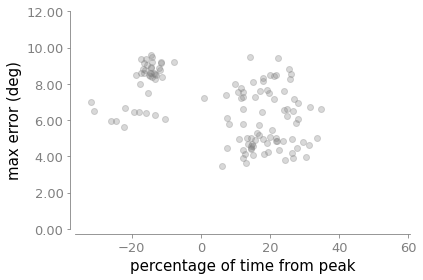

In [14]:
import glob
from matplotlib.ticker import FormatStrFormatter
import pathlib
from scipy.stats import spearmanr
path = r'C:\Phase1\results_temp\addexp_sign_time_err1\imu_mcp'
files = glob.glob(os.path.join(path, "*.csv"))
for file in files:
    df = pd.read_csv(file)
    plt.scatter(df.percent*100,abs(df.rec_err), alpha = 0.3, color = 'tab:gray')
    plt.ylim(0,12)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_position(('outward', 5))
plt.gca().spines['bottom'].set_position(('outward', 5))
plt.gca().spines['left'].set_color("tab:gray")
plt.gca().spines['bottom'].set_color("tab:gray")
plt.gca().grid(color='0.8', linestyle='--', linewidth=0.0);
plt.gca().tick_params(axis='x', colors='0.5')
plt.gca().tick_params(axis='y', colors='0.5')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.gca().set_ylabel("max error (deg)", fontsize=15)
plt.gca().set_xlabel("percentage of time from peak", fontsize=15)
plt.savefig(pathlib.Path(r"D:\ROMIU\ROMIU-Analysis\phase1_data_analysis\addexp_err_loc_mcp.svg"), bbox_inches="tight")

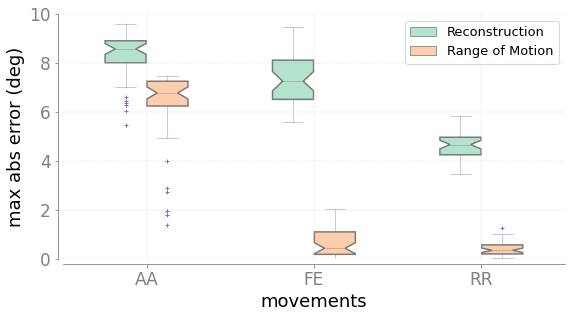

In [10]:
import seaborn as sns
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import pathlib
data_dir = r'C:\Phase1\results_temp\addexp_sign_time_err1\imu_mcp'
os.chdir(data_dir)
files = glob.glob('*csv')
data_shoulder=[]
for file1 in files:
    _data = pd.read_csv(file1)
    data_shoulder.append(abs(_data.rec_err))
    data_shoulder.append(abs(_data.rom_err))
RECONSTRUCTION  = {  "AA" : data_shoulder[0],
                     "FE" : data_shoulder[2],
                     'RR' : data_shoulder[4],
                    
         }
ROM  = { "AA" : data_shoulder[1],
         "FE" : data_shoulder[3],
         'RR' : data_shoulder[5],
         }

df = pd.DataFrame([[label, val, 'Reconstruction'] for label, values in RECONSTRUCTION.items() for val in values]
                  + [[label, val, 'Range of Motion'] for label, values in ROM.items() for val in values],
                  columns=['label', 'value', 'source'])


fig, ax = plt.subplots(figsize=(9, 4.5))
sns.boxplot(data=df, x='label', y='value', hue='source', palette= 'Pastel2', saturation = 1, width=0.5,
            notch=True,
            #    boxprops=dict(alpha=0.2),
               capprops=dict(color="tab:purple", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:purple", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:purple", markeredgecolor="tab:purple",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:gray", alpha=0.8, lw=0.5))
# plt.legend([], [], frameon=False)
# sns.swarmplot(data=df, x='label', y='value', hue='source', palette=['black', 'black'], dodge=True, legend=False, ax=ax)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Reconstruction", "Range of Motion"])
plt.legend(fontsize = '13',loc='upper right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.grid(color='0.8', linestyle='--', linewidth=0.35);
ax.tick_params(axis='x', colors='0.5')
ax.tick_params(axis='y', colors='0.5')
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax.legend(['REC','ROM'])

plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.ylim(0,10)
ax.set_ylabel("max abs error (deg)", fontsize=18)
ax.set_xlabel("movements", fontsize=18)
# background = plt.Rectangle((0.4, 0), 1, 1,
#                            transform=ax.transAxes,
#                            color='#EBF5FB', zorder=-1)
# ax.add_patch(background)
# ax.text(0.50, 0.97, "neck movements", ha="left", va="top", fontsize=18,
#         color="#3D3E3D", transform=ax.transAxes,)
# ax.text(0.10, 0.97, "shoulder movements", ha="left", va="top", fontsize=18,
#         color="#3D3E3D", transform=ax.transAxes,)
# fig.show()
fig.savefig(pathlib.Path(r"D:\ROMIU\ROMIU-Analysis\phase1_data_analysis\box_plt_err_mcp.svg"), bbox_inches="tight")

AA_final_err_after_threshold_corcn.csv
ER_final_err_after_threshold_corcn.csv
E_final_err_after_threshold_corcn.csv
FE_final_err_after_threshold_corcn.csv
F_final_err_after_threshold_corcn.csv
IR_final_err_after_threshold_corcn.csv
LLF_final_err_after_threshold_corcn.csv
LR_final_err_after_threshold_corcn.csv
RLF_final_err_after_threshold_corcn.csv
RR_final_err_after_threshold_corcn.csv


Text(0.1, 0.97, 'shoulder movements')

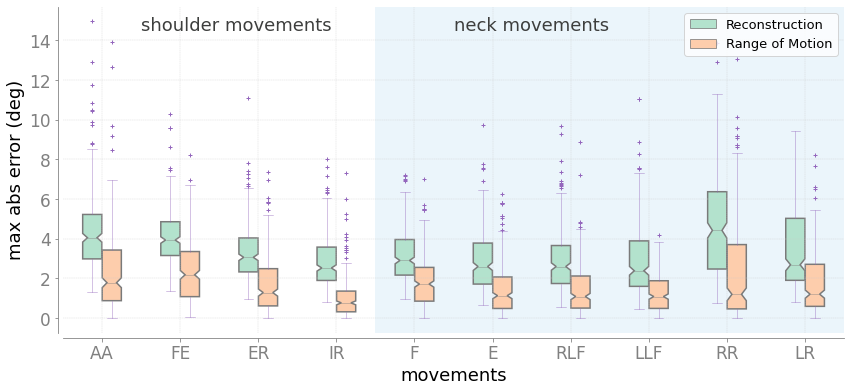

In [15]:
import seaborn as sns
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
data_dir = r'C:\Phase1\results_temp\alg_errors'
os.chdir(data_dir)
files = glob.glob('*csv')
data_shoulder=[]
for file1 in files:
    print(file1)
    _data = pd.read_csv(file1)
    data_shoulder.append(_data.gyro_recon_err)
    data_shoulder.append(_data.gyro_rom_err)
from matplotlib.ticker import FormatStrFormatter
import pathlib
RECONSTRUCTION  = {  "AA" : data_shoulder[0],
                     "FE" : data_shoulder[6],
                     "ER" : data_shoulder[2],
                     "IR" : data_shoulder[10],
                     'F': data_shoulder[8],
                     'E': data_shoulder[4],
                     'RLF': data_shoulder[16],
                     'LLF' : data_shoulder[12],
                     'RR' : data_shoulder[18],
                     'LR' : data_shoulder[14],
         }
ROM  = { "AA" : data_shoulder[1],
         "FE" : data_shoulder[7],
         "ER" : data_shoulder[3],
         "IR" : data_shoulder[11],
         'F': data_shoulder[9],
         'E': data_shoulder[5],
         'RLF': data_shoulder[17],
         'LLF' : data_shoulder[13],
         'RR' : data_shoulder[19],
         'LR' : data_shoulder[15],
         }

df = pd.DataFrame([[label, val, 'Reconstruction'] for label, values in RECONSTRUCTION.items() for val in values]
                  + [[label, val, 'Range of Motion'] for label, values in ROM.items() for val in values],
                  columns=['label', 'value', 'source'])


fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=df, x='label', y='value', hue='source', palette= 'Pastel2', saturation = 1, width=0.5,
            notch=True,
            #    boxprops=dict(alpha=0.2),
               capprops=dict(color="tab:purple", alpha=0.8, lw=0.5),
               whiskerprops=dict(color="tab:purple", alpha=0.8, lw=0.5),
               flierprops=dict(color="tab:purple", markeredgecolor="tab:purple",
                               markerfacecolor='tab:red', marker='+', markersize=4),
               medianprops=dict(color="tab:gray", alpha=0.8, lw=0.5))
# plt.legend([], [], frameon=False)
# sns.swarmplot(data=df, x='label', y='value', hue='source', palette=['black', 'black'], dodge=True, legend=False, ax=ax)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Reconstruction", "Range of Motion"])
plt.legend(fontsize = '13',loc='upper right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.grid(color='0.8', linestyle='--', linewidth=0.35);
ax.tick_params(axis='x', colors='0.5')
ax.tick_params(axis='y', colors='0.5')
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax.legend(['REC','ROM'])
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
ax.set_ylabel("max abs error (deg)", fontsize=18)
ax.set_xlabel("movements", fontsize=18)
background = plt.Rectangle((0.4, 0), 1, 1,
                           transform=ax.transAxes,
                           color='#EBF5FB', zorder=-1)
ax.add_patch(background)
ax.text(0.50, 0.97, "neck movements", ha="left", va="top", fontsize=18,
        color="#3D3E3D", transform=ax.transAxes,)
ax.text(0.10, 0.97, "shoulder movements", ha="left", va="top", fontsize=18,
        color="#3D3E3D", transform=ax.transAxes,)
# fig.show()
# fig.savefig(pathlib.Path(r"D:\ROMIU\ROMIU-Analysis\phase1_data_analysis\box_plt_err.svg"), bbox_inches="tight")

['C:\\Phase1\\IMU_data_copy\\001765p\\001765p_2\\shoulder\\e_rotation\\session2\\e001756p_2_ER_2.csv', 'C:\\Phase1\\IMU_data_copy\\001765p\\001765p_2\\shoulder\\e_rotation\\session2\\imu_session2.csv', 'C:\\Phase1\\IMU_data_copy\\001765p\\001765p_2\\shoulder\\e_rotation\\session2\\mcp_session2.csv']


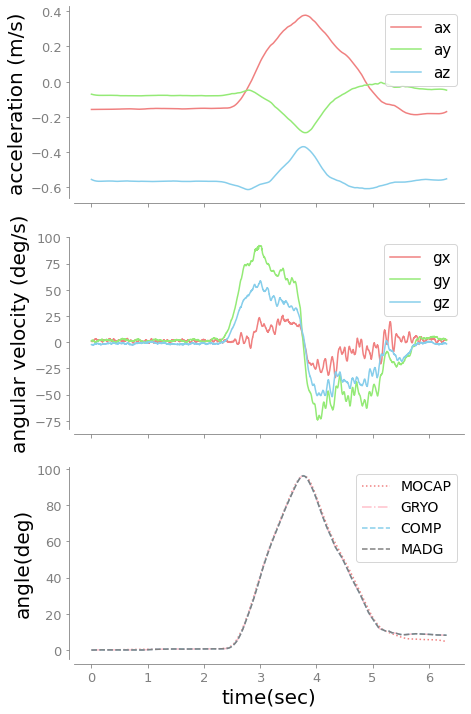

In [2]:
data_path = get_the_data_path(r'C:\Phase1\IMU_data_copy')  
err = np.zeros(6)
file = data_path[50]
print(file)
imu_file = file[1]
mcp_file = file[2]
imu = read_filter_data(imu_file, datacols=imu_col, filtcols=imu_col[3:6], sgwin=251, sgorder=3)
mcp = read_filter_data(mcp_file, datacols=mcp_col, filtcols=mcp_col[1:], sgwin=51, sgorder=3)
mcp = upsample_mocap_data(imu, mcp)
acc, gyro = imu_calibration(imu, acc_A, acc_bias, gyr_bias, 0)
mocap_ang = estimate_rotation_angle_from_mocap(mcp)
gyro_ang = angle_estimation_through_gyroscope(gyro, delta_t,inertial_quat)
comp_ang = angle_estimation_through_complementary_filter(gyro, acc, delta_t, inertial_quat, alpha)
madg_ang = angle_estimation_through_madgwick(gyro, acc,delta_t, beta, inertial_quat)
plt.rcParams["figure.figsize"] = [7.00, 12.00]
fg, ax = plt.subplots(3,sharex=True)
ax[0].plot(imu.Time, imu.accelx1, 'lightcoral')
ax[0].plot(imu.Time, imu.accely1, '#94EA76')
ax[0].plot(imu.Time, imu.accelz1, 'skyblue')
ax[1].plot(imu.Time, imu.gyrox1, 'lightcoral')
ax[1].plot(imu.Time, imu.gyroy1, '#94EA76')
ax[1].plot(imu.Time, imu.gyroz1, 'skyblue')

plt.xlabel('time(sec)', fontsize=20)
ax[0].set_ylabel('acceleration (m/s)', fontsize=20)
ax[1].set_ylabel('angular velocity (deg/s)',fontsize=20)
ax[0].legend(['ax','ay','az'],loc='upper right', fontsize=15)
ax[1].legend(['gx','gy','gz'],loc='upper right', fontsize=15)
ax[2].plot(imu.Time, mocap_ang, 'lightcoral',linestyle='dotted')
ax[2].plot(imu.Time, gyro_ang, 'pink', linestyle='dashdot')
ax[2].plot(imu.Time, comp_ang, 'skyblue', linestyle='dashed')
ax[2].plot(imu.Time, madg_ang,'gray',linestyle='dashed')
ax[2].set_ylabel('angle(deg)',fontsize=20)
ax[2].legend(['MOCAP','GRYO','COMP','MADG'],loc='upper right', fontsize=14)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_position(('outward', 5))
ax[0].spines['bottom'].set_position(('outward', 5))
ax[0].spines['left'].set_color("tab:gray")
ax[0].spines['bottom'].set_color("tab:gray")
ax[0].grid(color='0.8', linestyle='--', linewidth=0.0);
ax[0].tick_params(axis='x', colors='0.5')
ax[0].tick_params(axis='y', colors='0.5')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_position(('outward', 5))
ax[1].spines['bottom'].set_position(('outward', 5))
ax[1].spines['left'].set_color("tab:gray")
ax[1].spines['bottom'].set_color("tab:gray")
ax[1].grid(color='0.8', linestyle='--', linewidth=0.0);
ax[1].tick_params(axis='x', colors='0.5')
ax[1].tick_params(axis='y', colors='0.5')
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['left'].set_position(('outward', 5))
ax[2].spines['bottom'].set_position(('outward', 5))
ax[2].spines['left'].set_color("tab:gray")
ax[2].spines['bottom'].set_color("tab:gray")
ax[2].grid(color='0.8', linestyle='--', linewidth=0.0);
ax[2].tick_params(axis='x', colors='0.5')
ax[2].tick_params(axis='y', colors='0.5')
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax.legend(['REC','ROM'])
plt.xticks(fontsize = 13)
plt.setp(ax[0].get_yticklabels(), fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=13)
plt.setp(ax[2].get_yticklabels(), fontsize=13)
plt.show()
# fg.savefig(pathlib.Path(r"D:\ROMIU\ROMIU-Analysis\phase1_data_analysis\example_plt.svg"), bbox_inches="tight")
